### Deep Q Network for navigating through a grid world with different goal locations
#### Reward system 1: Negative of euclidean distance to goal - Did not converge for 250 episodes
#### Reward system 2: As per the paper - "Autonomous Navigation of an AMR using Deep Reinforcement Learning in a Warehouse Environment" (Episode terminates if the bot hits the bounds)

##### Final model name: doublenet_dqn_diff_start_diff_goal_300ep_pt2.h5

In [3]:
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

2023-07-23 20:39:33.527451: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 20:39:34.210113: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 20:39:34.213546: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 20:39:36.358135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# print gpu info
print(tf.config.list_physical_devices('GPU'))


In [2]:
# Create a neural network model
def create_model(input_shape, num_actions):
    model = Sequential([
        Input(shape=input_shape),
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_actions, activation='linear')
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0008))
    return model

In [4]:
# Create a class for the environment
class Env():
    def __init__(self, grid_size=11, max_steps=500):
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.goal = np.random.randint(0, grid_size, size=2) # random goal
        print('Goal:', self.goal)

        self.rewards = np.zeros((grid_size, grid_size))
        self.reset()

    def reset(self):
        self.pos = np.random.randint(0, self.grid_size, size=2)
        self.steps = 0
        self.done = False
        return self.pos
    
    def reset_goal(self):
        self.goal = np.random.randint(0, self.grid_size, size=2)
        print('Goal:', self.goal)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.rewards[i, j] = -self.euclidean_distance_from_goal(np.array([i, j]))
        self.rewards[self.goal[0], self.goal[1]] = 100
        return self.goal
    

    def step(self, action): # As per the paper
        self.steps += 1
        prev_pos = self.pos.copy()
        if action == 0 and self.pos[0] < self.grid_size - 1: # right
            self.pos[0] += 1
        elif action == 1 and self.pos[0] > 0: # left
            self.pos[0] -= 1
        elif action == 2 and self.pos[1] > 0: # down
            self.pos[1] -= 1
        elif action == 3 and self.pos[1] < self.grid_size - 1: # up
            self.pos[1] += 1
        else:
            reward = -150
            self.done = True
            return self.pos, reward, self.done, True # TODO: The episode is not terminated.
        if np.array_equal(self.pos, self.goal):
            self.done = True
            reward = 500
        elif self.steps >= self.max_steps:
            self.done = True
            reward = self.rewards[self.pos[0], self.pos[1]]
        else:
            if self.euclidean_distance_from_goal(self.pos) < self.euclidean_distance_from_goal(prev_pos):
                reward = 10
            else:
                reward = -10
        return self.pos, reward, self.done, False
        

    def euclidean_distance_from_goal(self, pos):
        dist = np.sqrt(np.sum((pos - self.goal) ** 2))
        return dist
        
        

In [5]:
# Create an agent class
class Agent():
    def __init__(self, env, model, target_model):
        self.env = env
        self.model = model
        self.target_model = target_model
        self.target_model.set_weights(self.model.get_weights())
        self.gamma = 0.7
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.01
        self.batch_size = 64
        self.memory = deque(maxlen=10000)
        

    def add_to_memory(self, state, goal, action, reward, next_state, done):
        self.memory.append((state, goal, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 4)
        else:
            # Pre-process the input
            inputt = np.concatenate((state, self.env.goal))
            inputt = tf.convert_to_tensor(inputt)
            inputt = tf.expand_dims(inputt, 0)

            return np.argmax(self.model.predict(inputt, verbose=0)[0]) # TODO: check the predict output

    def predict(self, inputt):

        return np.argmax(self.model.predict(inputt, verbose=0)[0])

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, goal, action, reward, next_state, done in batch:
            
            target = reward

            if not done:
                # Pre-process the next state input
                input_next = np.concatenate((next_state, goal))
                input_next = tf.convert_to_tensor(input_next)
                input_next = tf.expand_dims(input_next, 0)

                target += self.gamma * np.amax(self.target_model.predict(input_next, verbose=0)[0])

            # Pre-process the current state input
            inputt = np.concatenate((state, goal))
            inputt = tf.convert_to_tensor(inputt)
            inputt = tf.expand_dims(inputt, 0)

            cur_q_value = self.model.predict(inputt, verbose=0) # Q-value of current state
            cur_q_value[0][action] = target # TODO: check the predict output
            
            self.model.fit(inputt, cur_q_value, epochs=1, verbose=0)
            

In [6]:
# Initialize the agent

try:
    model = tf.keras.models.load_model('ashvin_train.h5')
    print("Loaded model from disk")
    agent = Agent(Env(), model=model, target_model=model)
except:
    print("Creating new model")
    agent = Agent(Env(), model=create_model(input_shape=(4,), num_actions=4), target_model=create_model(input_shape=(4,), num_actions=4))


Loaded model from disk
Goal: [7 0]


In [10]:
# Train the agent

num_episodes = 300
reward_lst = []


for episode in range(num_episodes):
    state = agent.env.reset()   
    for step in range(agent.env.max_steps):
        action = agent.act(state)
        next_state, reward, done, terminate = agent.env.step(action)
        agent.add_to_memory(state, agent.env.goal, action, reward, next_state, done)
        state = next_state
        if done:
            if np.array_equal(agent.env.goal, agent.env.pos): # Reached the goal
                agent.env.reset_goal()
            if (agent.env.steps >= agent.env.max_steps) or terminate:
                print('Episode: {}/{}, steps: {}, e: {:.2}'.format(episode, num_episodes, step+1, agent.epsilon))
                break
    if len(agent.memory) > agent.batch_size:
        agent.replay()
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = (1 - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode) + agent.epsilon_min
    if episode % 5 == 0:
        agent.model.save('ashvin_train.h5')    

    agent.target_model.set_weights(agent.model.get_weights())

    
print('Average reward:', np.mean(reward_lst))

Episode: 0/300, steps: 10, e: 1.0
Episode: 1/300, steps: 58, e: 1.0
Episode: 2/300, steps: 14, e: 0.99
Episode: 3/300, steps: 123, e: 0.98
Episode: 4/300, steps: 103, e: 0.97
Episode: 5/300, steps: 9, e: 0.96
Episode: 6/300, steps: 23, e: 0.95
Episode: 7/300, steps: 7, e: 0.94
Episode: 8/300, steps: 5, e: 0.93
Goal: [4 5]
Episode: 9/300, steps: 17, e: 0.92
Goal: [8 6]
Episode: 10/300, steps: 46, e: 0.91
Goal: [3 5]
Episode: 11/300, steps: 12, e: 0.91
Episode: 12/300, steps: 12, e: 0.9
Episode: 13/300, steps: 32, e: 0.89
Goal: [1 6]
Episode: 14/300, steps: 53, e: 0.88
Episode: 15/300, steps: 15, e: 0.87
Episode: 16/300, steps: 40, e: 0.86
Episode: 17/300, steps: 12, e: 0.85
Episode: 18/300, steps: 4, e: 0.85
Goal: [0 3]
Goal: [7 9]
Episode: 19/300, steps: 8, e: 0.84
Goal: [0 6]
Episode: 20/300, steps: 32, e: 0.83
Episode: 21/300, steps: 2, e: 0.82
Episode: 22/300, steps: 1, e: 0.81
Episode: 23/300, steps: 62, e: 0.8
Goal: [7 1]
Episode: 24/300, steps: 3, e: 0.8
Episode: 25/300, steps: 6

KeyboardInterrupt: 

In [7]:
# Test the agent
success = 0
crash = 0
for i in range(100):
    state = agent.env.reset()
    goal = agent.env.reset_goal()
    print('Goal:', goal)
    for step in range(30):
        print('State:', state)
        inputt = np.concatenate((state, goal))
        inputt = tf.convert_to_tensor(inputt)
        inputt = tf.expand_dims(inputt, 0)
        action = agent.predict(inputt)
        next_state, reward, done, terminate = agent.env.step(action)
        state = next_state
        if done:
            print('State:', state)
            print('Steps: ', step+1)
            if np.array_equal(agent.env.goal, agent.env.pos):
                print('Reached the goal!')
                success += 1
            break
        if terminate:
            print('Steps: ', step+1)
            print("Crashed into a wall")
            crash += 1
            break

print('Success rate:', success/100)
print('Crash rate:', crash/100)
print('Oscillate rate:', (100 - success - crash)/100)

Goal: [7 4]
Goal: [7 4]
State: [6 8]
State: [6 7]
State: [6 6]
State: [6 5]
State: [6 4]
State: [6 3]
State: [7 3]
State: [6 3]
State: [7 3]
State: [6 3]
State: [7 3]
State: [6 3]
State: [7 3]
State: [6 3]
State: [7 3]
State: [6 3]
State: [7 3]
State: [6 3]
State: [7 3]
State: [6 3]
State: [7 3]
State: [6 3]
State: [7 3]
State: [6 3]
State: [7 3]
State: [6 3]
State: [7 3]
State: [6 3]
State: [7 3]
State: [6 3]
Goal: [1 0]
Goal: [1 0]
State: [7 5]
State: [6 5]
State: [6 4]
State: [6 3]
State: [5 3]
State: [5 2]
State: [4 2]
State: [4 1]
State: [3 1]
State: [3 0]
State: [2 0]
State: [2 0]
Steps:  11
Goal: [ 7 10]
Goal: [ 7 10]
State: [1 1]
State: [2 1]
State: [2 2]
State: [2 3]
State: [2 4]
State: [3 4]
State: [3 5]
State: [4 5]
State: [4 6]
State: [4 7]
State: [5 7]
State: [5 8]
State: [5 9]
State: [6 9]
State: [5 9]
State: [6 9]
State: [5 9]
State: [6 9]
State: [5 9]
State: [6 9]
State: [5 9]
State: [6 9]
State: [5 9]
State: [6 9]
State: [5 9]
State: [6 9]
State: [5 9]
State: [6 9]
Sta

In [15]:
# testing for custom goal and random start point:
state = agent.env.reset()
goal = agent.env.reset_goal()
# print('Goal:', goal)

for step in range(30):
    print('State:', state)
    inputt = np.concatenate((state, goal))
    inputt = tf.convert_to_tensor(inputt)
    inputt = tf.expand_dims(inputt, 0)
    action = agent.predict(inputt)
    next_state, reward, done, terminate = agent.env.step(action)
    state = next_state
    if done:
        print('State:', state)
        print('Steps: ', step+1)
        if np.array_equal(agent.env.goal, agent.env.pos):
            print('Reached the goal!')
        break
    if terminate:
        print('Steps: ', step+1)
        print("Crashed into a wall")
        break

Goal: [4 7]
State: [1 2]
State: [1 3]
State: [2 3]
State: [2 4]
State: [2 5]
State: [3 5]
State: [3 6]
State: [3 7]
State: [4 7]
Steps:  8
Reached the goal!


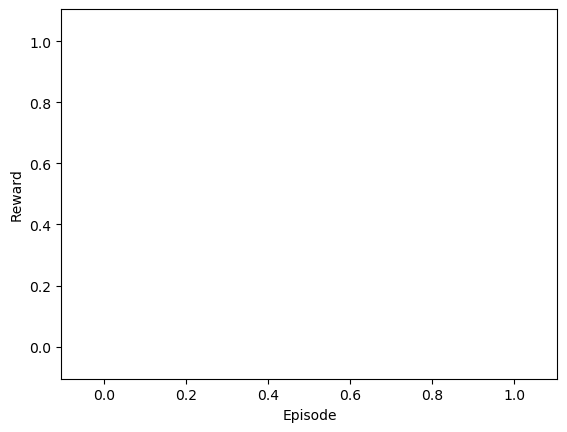

In [12]:
import matplotlib.pyplot as plt
plt.plot(reward_lst)
plt.xlabel("Episode")
plt.ylabel("Reward")
# PLot mean line for 10 episodes
mean_lst = []
for i in range(len(reward_lst)):
    if i < 10:
        mean_lst.append(np.mean(reward_lst[:i+1]))
    else:
        mean_lst.append(np.mean(reward_lst[i-10:i+1]))
plt.plot(mean_lst)
plt.show()


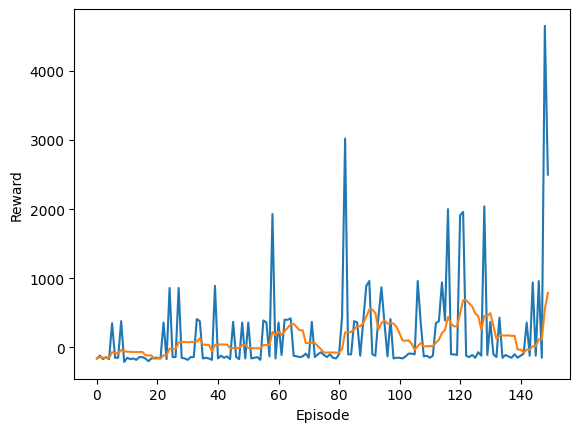

#### Test Results:

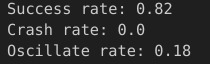

##### Hyperparameters:

- Learning rate: 0.0008
- Discount factor (gamma): 0.7
- Epsilon: 1.0
- Epsilon decay: 0.01
- Epsilon min: 0.01
- Batch size: 64
- Memory size: 10000
- Target update frequency: 1/5 (every 5 episodes)
- Number of episodes: 250
- Number of steps per episode: 500
- Number of hidden layers: 2
- Number of neurons in hidden layers: 16, 32
- Activation function: ReLU
- Optimizer: Adam
- Loss function: MSE


In [ ]:
agent.model.save('doublenet_dqn_diff_start_diff_goal_300ep_pt2_backup.h5')